# Анализ убытков приложения ProcrastinatePRO+

В распоряжении имеются данные развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев  бизнес постоянно нес убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Необходимо  разобраться в причинах этой ситуации.

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Предстоит изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.


#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

   - User Id — уникальный идентификатор пользователя
   - Device — категория устройства пользователя
   - Session start — дата и время начала сессии
   - Session End — дата и время окончания сессии
   - Channel — идентификатор рекламного источника, из которого пришел пользователь
   - Region - страна пользователя

Таблица orders_log_short (информация о заказах):

   - User Id — уникальный id пользователя, который сделал заказ
   - Event Dt — дата и время покупки
   - Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

   - Channel — идентификатор рекламного источника
   - Dt — дата
   - Costs — затраты на этот рекламный источник в этот день

# Шаг 1. Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # покупки
    pd.read_csv('/datasets/costs_info_short.csv'),  # траты на рекламу
)

In [2]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


пропусков нет

Приведем названия столбцов к правильному виду

In [4]:
visits.columns = [x.lower().replace(' ', '_') for x in visits.columns]

Приведем начало и окончание сессий к datetime

In [5]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

In [6]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Приведем названия столбцов к правильному виду

In [7]:
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns]

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


пропусков нет

Приведем event_dt к datetime

In [9]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [10]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Приведем названия столбцов к правильному виду

In [11]:
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns]

In [12]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


пропусков нет

Приведем dt к datetime

In [13]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

# Шаг 2. Зададим функции для расчета и анализа LTV, ROI, удержания и конверсии



In [14]:
# функция для создания профелей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
#     for event in event_names:
#         if event in events['event_name'].unique():
#             profiles[event] = profiles['user_id'].isin(
#                 events.query('event_name == @event')['user_id'].unique()
#             )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles



In [15]:
# функция для расчета удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time



In [ ]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [17]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [18]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):
    
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    plt.tight_layout()
    plt.show() 

    # функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=20):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window = 7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# Шаг 3. Исследовательский анализ данных

Выясним:
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

### 3.1. Создадим пользовательские профили. Определим минимальную и максимальную даты привлечения пользователей.

In [19]:
# построим профили пользователей
profiles = get_profiles(visits, orders, costs)

profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [20]:
print('Минимальная дата привлечения пользователей:', profiles.dt.min())
print('Максимальная дата привлечения пользователей:', profiles.dt.max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


### 3.2 Посмотрим из каких стран приходят посетители, выясним какие страны дают больше всего платящих пользователей

In [21]:
# Для удобства напишем функцию, которая создает таблицу, 
# отражающую количество пользователей и долю платящих по определенному признаку (столбцу)
def create_table(column):
    
    all_users = profiles[column].value_counts().to_frame()
    paying_users = profiles.query('payer == True')[column].value_counts().to_frame()
    paying_users_proportion=(profiles.query('payer == True')[column].value_counts()
                        / profiles[column].value_counts())
    
    table = pd.merge(all_users, 
                     paying_users, 
                     left_index=True, 
                     right_index=True).merge(paying_users_proportion,      
                                             left_index=True, 
                                             right_index=True).rename(columns={column+'_x': 'users_count', 
                                                                               column+'_y':'paying_users',
                                                                               column:'paying_users_proportion' })
    return table.style.format('{:.3f}')

In [22]:
# Также напишем функцию, которая визуализирует данные в полученной таблице
def viz_users_paying(column):    
    
    table = create_table(column).data
    
    plt.figure(figsize=(18, 5))
    ax1 = plt.subplot(1, 3, 1)
    table.iloc[:,0].sort_values(ascending=False).plot(kind = 'bar',
                                                        legend = False,
                                                        ax=ax1
                                                       )

    plt.ylabel('Кол-во пользователй', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.title('Все пользователи', fontsize=14)

    ax2 = plt.subplot(1, 3, 2)
    table.iloc[:,1].sort_values(ascending=False).plot(kind = 'bar',
                                                       legend = False,
                                                       ax=ax2,
                                                       color='green'
                                                      )

    plt.ylabel('Кол-во платящих пользователей', fontsize=12)
    plt.xlabel(column, fontsize=12)
    plt.title('Платящие пользователи', fontsize=14)

    ax3 = plt.subplot(1, 3, 3)
    table.iloc[:,2].sort_values(ascending=False).plot(kind = 'bar',
                                                       legend = False,
                                                       ax=ax3,
                                                       color='orange'
                                                      )
    plt.ylabel('Доля платящих пользователей', fontsize=12)
    plt.xlabel(column, fontsize=13)
    plt.title('Доля платящих пользователей', fontsize=14)
    plt.show()

In [23]:
create_table('region')

,users_count,paying_users,paying_users_proportion
United States,100002.000,6902.000,0.069
UK,17575.000,700.000,0.040
France,17450.000,663.000,0.038
Germany,14981.000,616.000,0.041


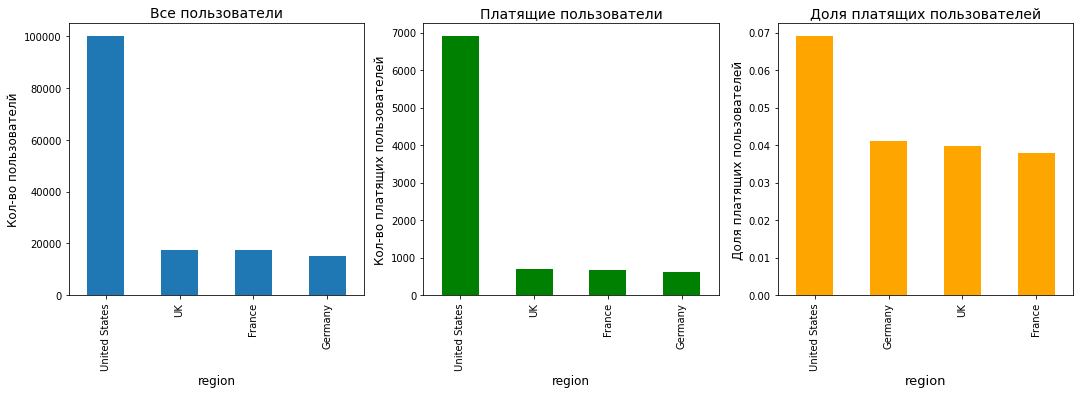

In [24]:
viz_users_paying('region')

Видим, что больше всего пользоваталей привлекаются в США, наибольшая доля платящих пользователей также наблюдается в США. Количество привлеченных пользователй и доля платящих для других стран примерно одинакова

### 3.3 Выясним какими устройствами пользуются. Определим с каких устройств чаще всего заходят платящие пользователи


In [25]:
create_table('device')

,users_count,paying_users,paying_users_proportion
iPhone,54479.000,3382.000,0.062
Android,35032.000,2050.000,0.059
PC,30455.000,1537.000,0.050
Mac,30042.000,1912.000,0.064


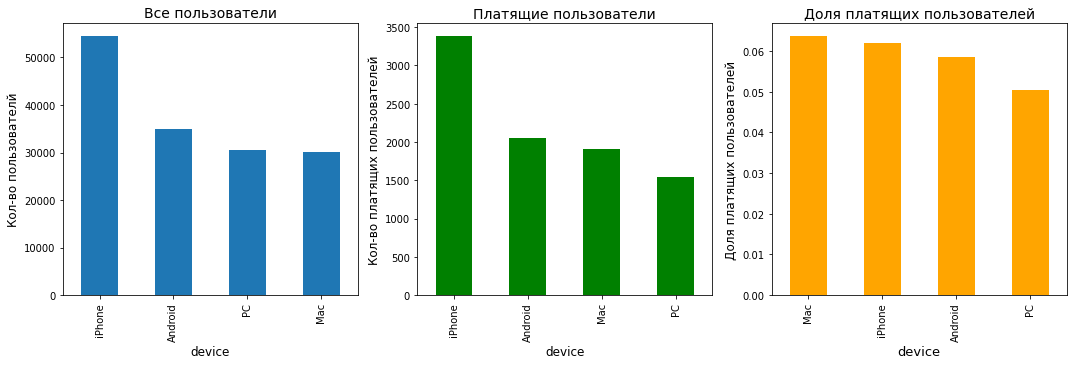

In [26]:
viz_users_paying('device')

Видим, что больше всего пользователей заходят с iPhone и Android. Наибольшая доля платящих пользователей наблюдается для Mac и iPhone

### 3.4 Посмотрим каналы привлечения пользователей, выясним какие каналы приносят больше всего платящих пользователей


In [27]:
create_table('channel')

,users_count,paying_users,paying_users_proportion
organic,56439.000,1160.000,0.021
FaceBoom,29144.000,3557.000,0.122
TipTop,19561.000,1878.000,0.096
OppleCreativeMedia,8605.000,233.000,0.027
WahooNetBanner,8553.000,453.000,0.053
LeapBob,8553.000,262.000,0.031
RocketSuperAds,4448.000,352.000,0.079
MediaTornado,4364.000,156.000,0.036
YRabbit,4312.000,165.000,0.038
AdNonSense,3880.000,440.000,0.113


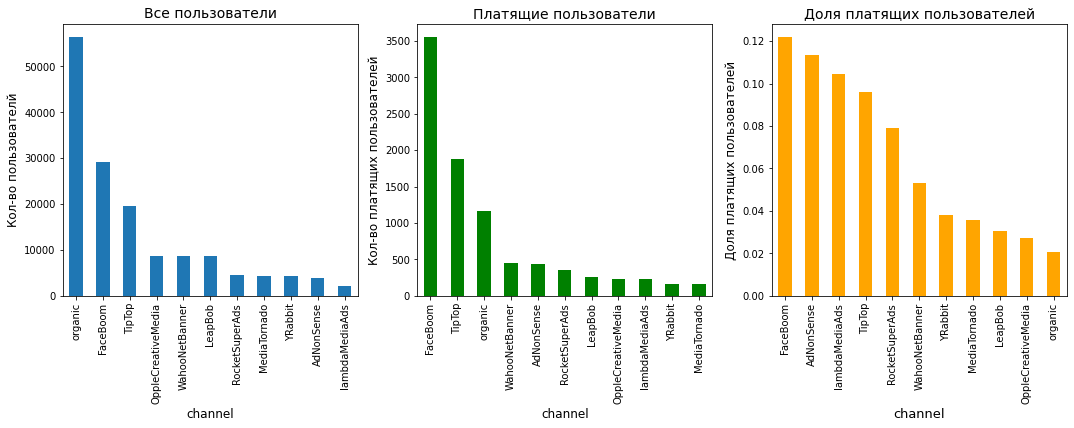

In [28]:
viz_users_paying('channel')

Больше всего привлекаются organic-пользователи, далее идут каналы FaceBoom, TipTop и другие. Среди платящих пользователей больше всего привлекаются по каналу FaceBoom.
Наибольшая доля платящих пользователей наблюдается для каналов FaceBoom, AdNonSense, lambdaMediaAds

### Выводы:
-  Больше всего пользоваталей привлекаются в США, наибольшая доля платящих пользователей также наблюдается в США. Количество привлеченных пользователй и доля платящих для других стран примерно одинакова
- Больше всего пользователей заходят с iPhone и Android. Наибольшая доля платящих пользователей наблюдается для Mac и iPhone
- Больше всего привлекаются organic-пользователи, далее идут каналы FaceBoom, TipTop и другие. Среди платящих пользователей больше всего привлекаются по каналу FaceBoom. Наибольшая доля платящих пользователей наблюдается для каналов FaceBoom, AdNonSense, lambdaMediaAds

# Шаг 4. Маркетинг

Выясним:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

### 4.1 Посчитаем общую сумму расходов на маркетинг. Выясним, как траты распределены по источникам. Визуализируем изменения метрик во времени.

In [29]:
print(f"Общая сумма расходов на маркетинг: {costs.costs.sum():.2f}")

Общая сумма расходов на маркетинг: 105497.30


Выясним как траты на маркетинг распределены по источникам привлечения

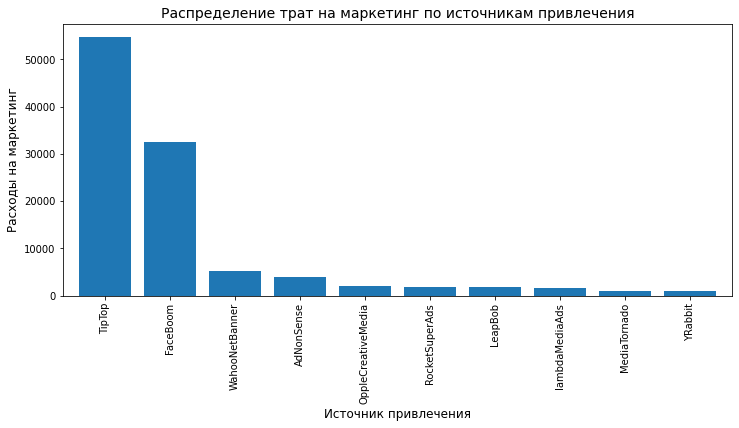

In [30]:
plt.figure(figsize=(12, 5))

costs.groupby('channel').costs.sum().sort_values(ascending=False).plot(kind = 'bar',
                                                                       legend = False,
                                                                       width = 0.8,
                                                                       )

plt.ylabel('Расходы на маркетинг', fontsize=12)
plt.xlabel('Источник привлечения', fontsize=12)
plt.title('Распределение трат на маркетинг по источникам привлечения', fontsize=14);

Визуализируем расходы на маркетинг во времени

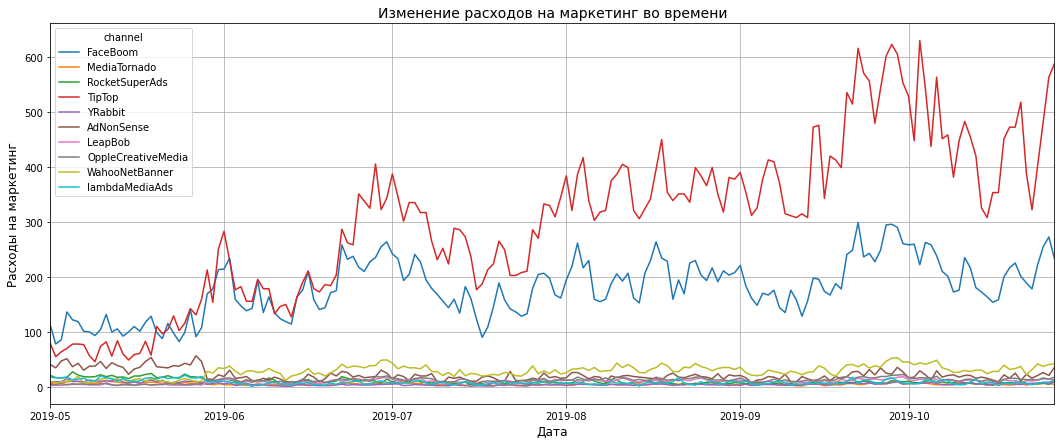

In [31]:
plt.figure(figsize=(18, 7))
sns.lineplot(data=costs, x="dt", y="costs", hue="channel")
plt.grid()
plt.xlim(costs.dt.min(),costs.dt.max())
plt.ylabel('Расходы на маркетинг', fontsize=12)
plt.xlabel('Дата', fontsize=12)
plt.title('Изменение расходов на маркетинг во времени', fontsize=14);

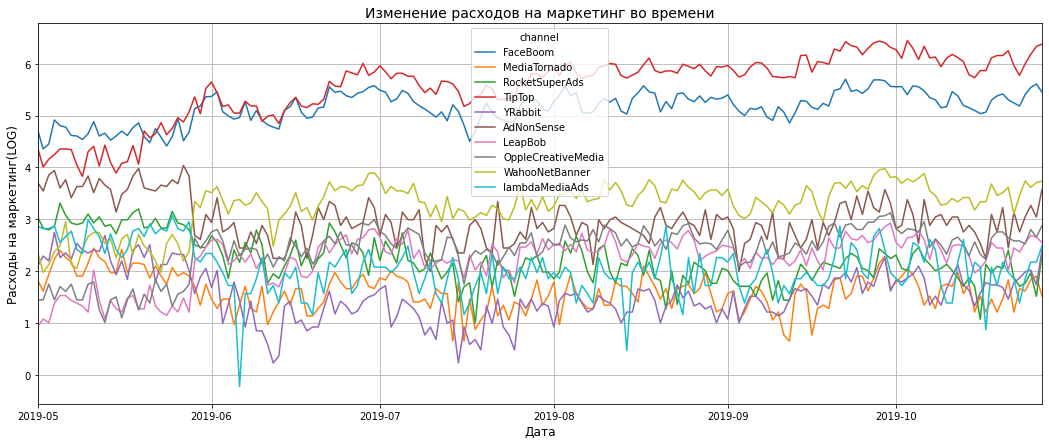

In [32]:
# Для удобства сравнения трендов изменения расходов построим график в логорифмическом масштабе
costs['logcosts'] = costs.costs.apply(np.log)
plt.figure(figsize=(18, 7))
sns.lineplot(data=costs, x="dt", y="logcosts", hue="channel")
plt.grid()
plt.xlim(costs.dt.min(),costs.dt.max())
plt.ylabel('Расходы на маркетинг(LOG)', fontsize=12)
plt.xlabel('Дата', fontsize=12)
plt.title('Изменение расходов на маркетинг во времени', fontsize=14)
costs.drop(columns='logcosts',inplace=True);

### 4.2. Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика.

Узнаем, сколько в среднем стоило привлечение одного пользователя из каждого источника. Рассчитаем средний CAC на одного пользователя для всего проекта и для каждого источника трафика. 

In [33]:
mean_cac = profiles.query('channel != "organic"')['acquisition_cost'].mean()
print(f"Средняя стоимость привлечения пользователя для всего проекта: {mean_cac:.2f}")


Средняя стоимость привлечения пользователя для всего проекта: 1.13


Text(0.5, 1.0, 'Cредняя стоимость привлечения пользователя в зависимости от источника')

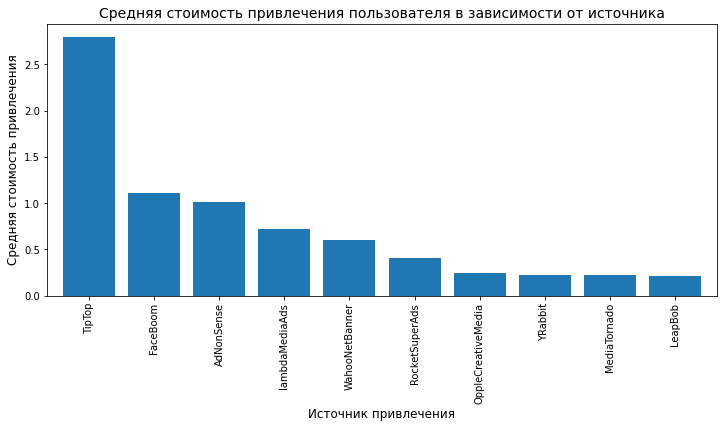

In [34]:
plt.figure(figsize=(12, 5))



profiles.query('channel != "organic"').groupby('channel').acquisition_cost.mean().sort_values(ascending=False).plot(kind = 'bar',
                                                                                       legend = False,
                                                                                       width = 0.8,
                                                                                       )

plt.ylabel('Cредняя стоимость привлечения', fontsize=12)
plt.xlabel('Источник привлечения', fontsize=12)
plt.title('Cредняя стоимость привлечения пользователя в зависимости от источника', fontsize=14)

### Выводы:
- Общая сумма расходов на маркетинг: 105497.30. Основные маркетинговые расходы приходятся на каналы привлечения FaceBoom и TipTop.
- Расходы на маркетинг для канала FaceBoom со временем существенно растут: с мая по ноябрь расходы выросли в 6 раз. Для остальных каналов рост расходов со временем не так  выражен. В целом, для когорт от июня тренды изменения расходов на маркетинг со временем схожи для основных каналов привлечения
- Средняя стоимость привлечения одного пользователя для проекта в целом: 1.13. Наибольшая стоимость привлечения одного пользователя наблюдается для каналов TipTop, FaceBoom и AdNonSense


# Шаг 5. Оценим окупаемость рекламы для привлечения пользователей



Положим, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

In [35]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### 5.1. Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

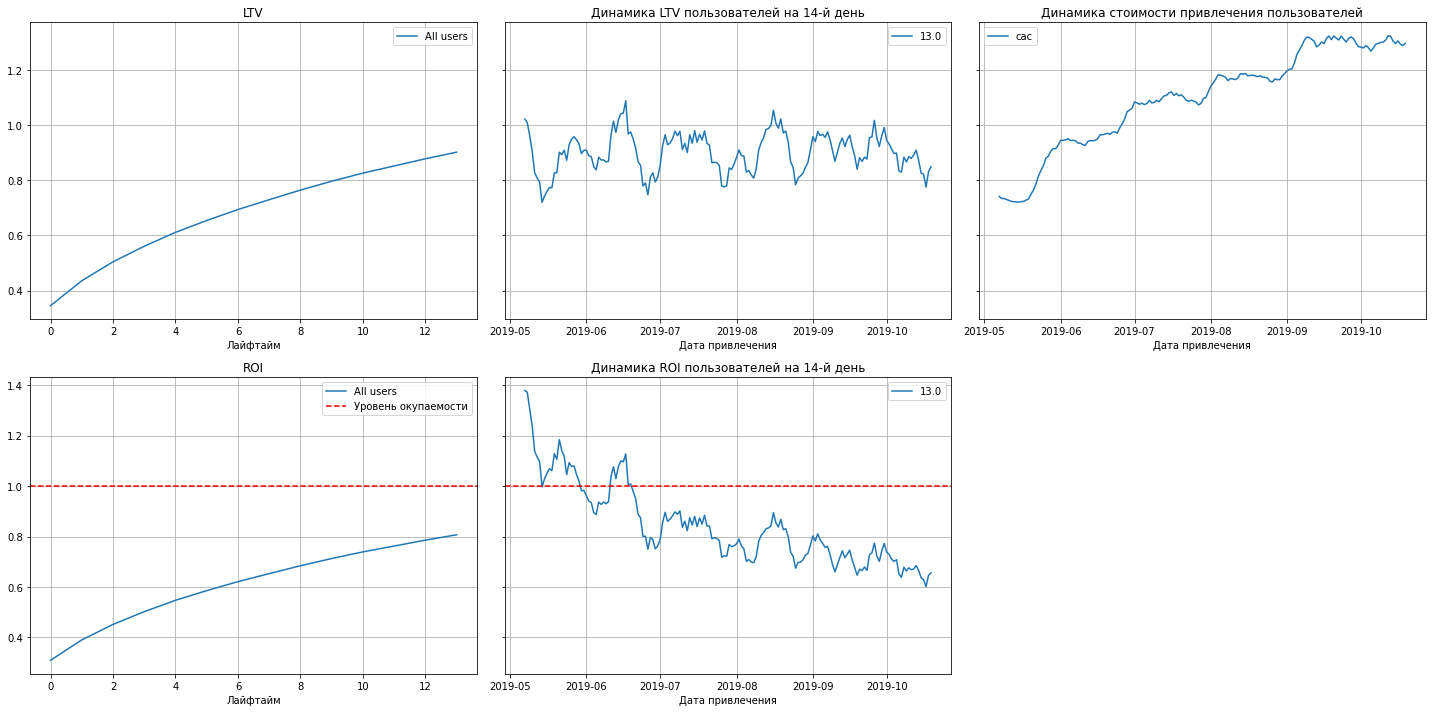

In [36]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)


Видим, что для проекта в целом реклама не окупается, даже к 14 дню ROI не достигает 100%. Стоимость привлечения имеет резкий рост в июне 2019г. ROI для пользователей, привлеченных с июня резко падает. На динамике LTV не заметно какой-либо сезонности, данный показатель достаточно стабилен.

### 5.2. Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

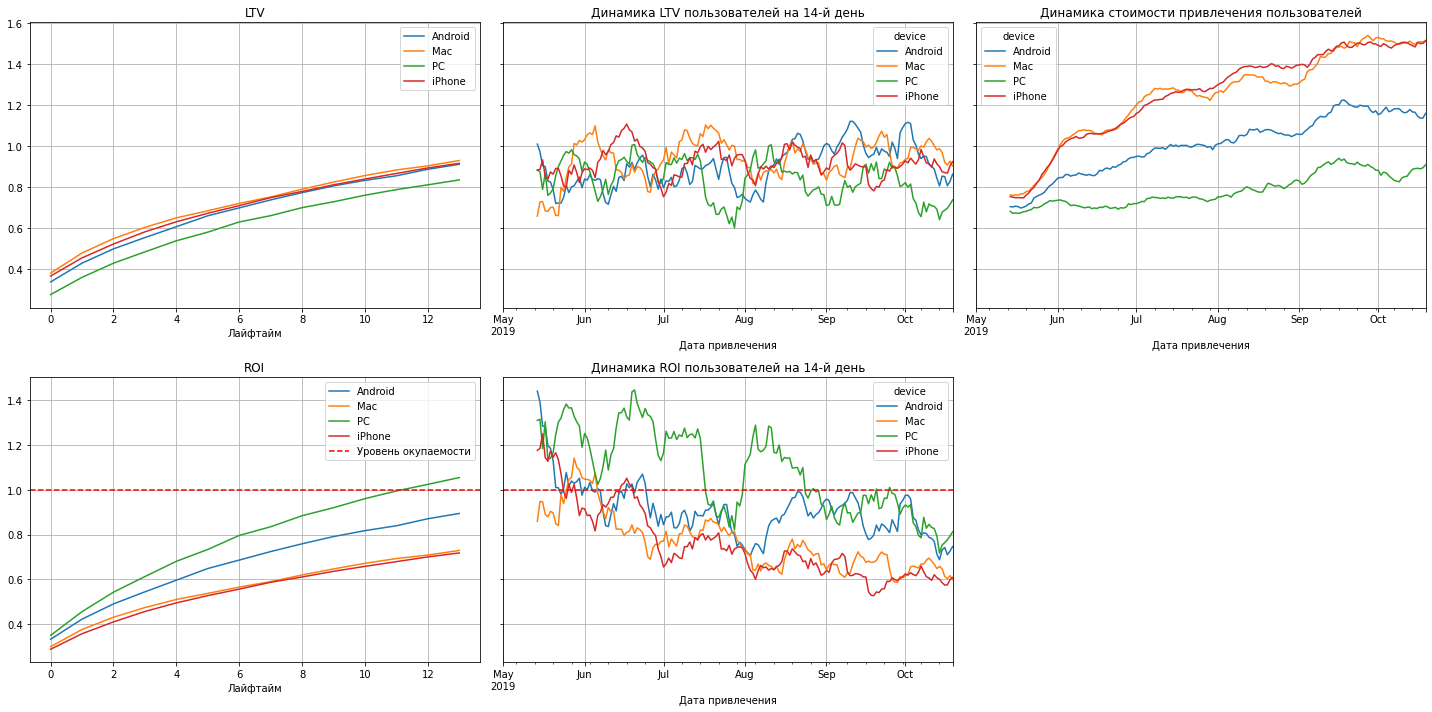

In [37]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

При разбивке по устройствам видим, что из всех устройств окупаются только пользователи PC, хоть и не очень стабильно: для когорт второй половины июля и сентября-октября окупаемость падает

### 5.3. Проанализируем окупаемость рекламы с разбивкой по каналам привлечения. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

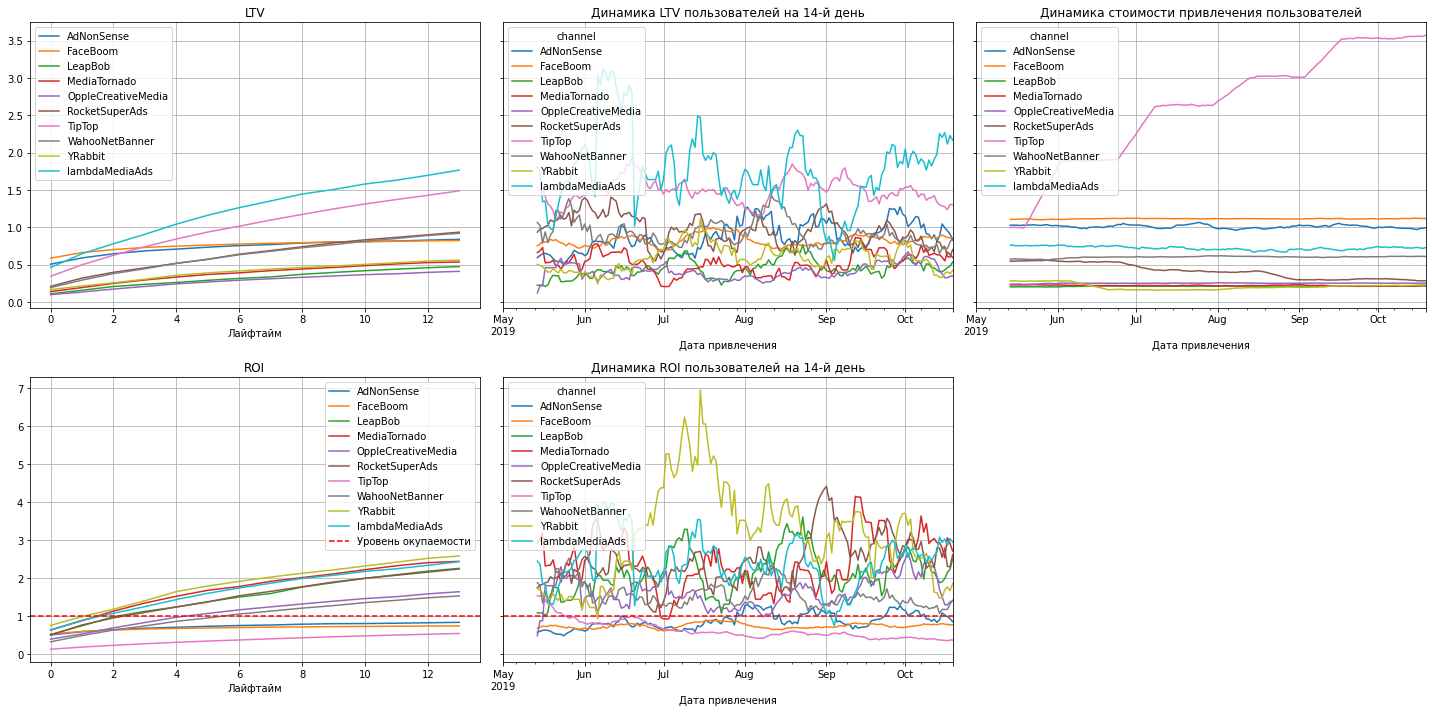

In [38]:
# смотрим окупаемость с разбивкой по каналам

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

При разбивке по источникам видим, что из всех каналов привлечения, проблемы с окупаемостью имеются у FaceBoom, TipTop и AdNonSense. Нужно отметить, что именно с этими каналами связаны наибольшие инвестиции в маркетинг. Лучше всего окупаются пользователи канала YRabbit

### 5.4. Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

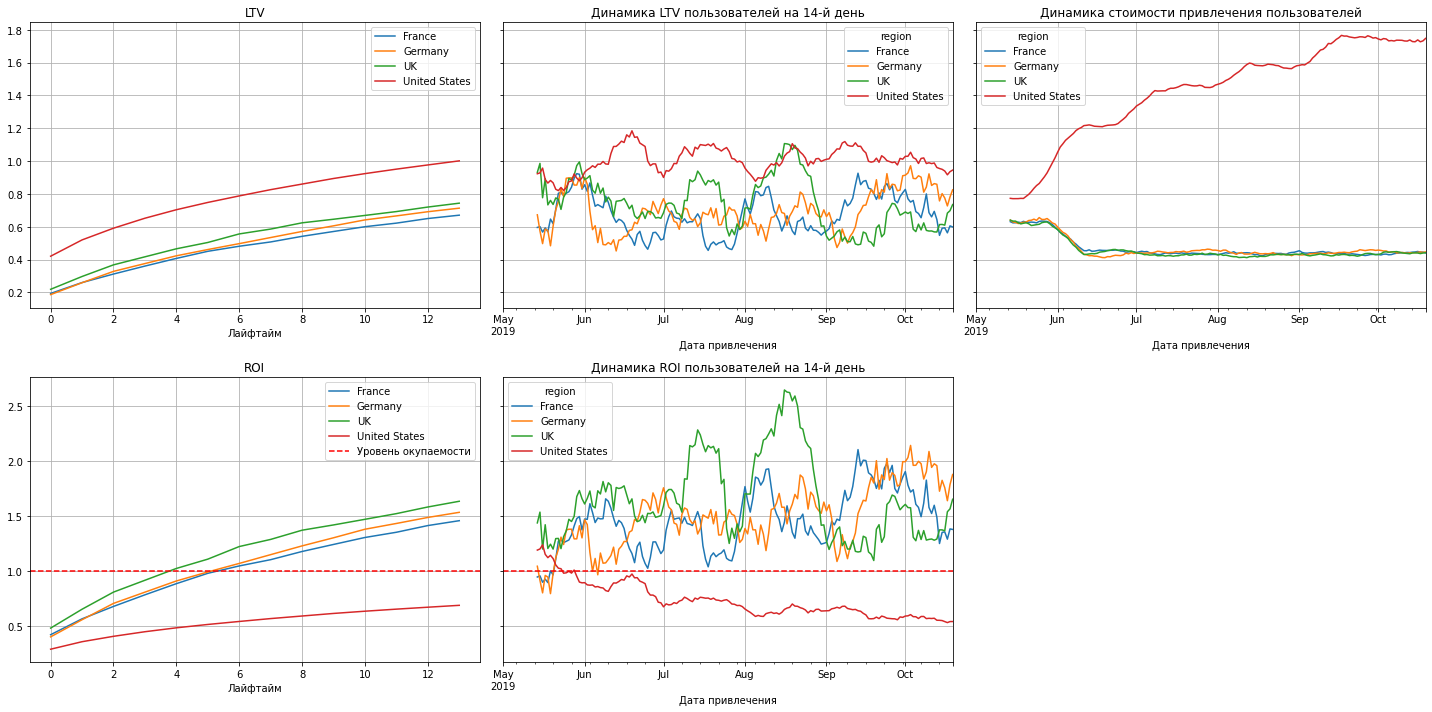

In [39]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)



При разбивке по странам, видим, что пользователи всех стран, кроме США стабильно хорошо окупаются

### Выводы:
- Видим, что для проекта в целом реклама не окупается, даже к 14 дню ROI не пдостигает 100%. Стоимость привлечения имеет резкий рост в июне 2019г. ROI для пользователей, привлеченных с июня резко падает. На динамике LTV не заметно какой-либо сезонности, данный показатель достаточно стабилен.
- При разбивке по устройствам видим, что из всех устройств окупаются только пользователи PC, хоть и не очень стабильно: для когорт второй половины июля и сентября-октября окупаемость падает
- При разбивке по источникам видим, что из всех каналов привлечения, проблемы с окупаемостью имеются у FaceBoom, TipTop и AdNonSense. Нужно отметить, что именно с этими каналами связаны наибольшие инвестиции в маркетинг. Лучше всего окупаются пользователи канала YRabbit
- При разбивке по странам, видим, что пользователи всех стран, кроме США стабильно хорошо окупаются. С США связаны наибольшие инвестиции в маркетинг, стоимость привлечения пользователей из США во много раз превышает соимость привлечения пользователей в других странах


### 5.4. Построим и изучим графики конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

При оценке конверсии и удержания не будем учитывать organic-пользователей, т.к. их стоимость привлечения нулевая и в данном случае они не вызывают каких-либо проблем

In [42]:
profiles

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769
...,...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:02,TipTop,iPhone,United States,2019-09-28,2019-09-01,False,3.500000
150004,999975439887,2019-10-21 00:35:17,organic,PC,UK,2019-10-21,2019-10-01,False,0.000000
150005,999976332130,2019-07-23 02:57:06,TipTop,iPhone,United States,2019-07-23,2019-07-01,False,2.600000
150006,999979924135,2019-09-28 21:28:09,MediaTornado,PC,United States,2019-09-28,2019-09-01,False,0.205714


In [43]:
orders

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


In [ ]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

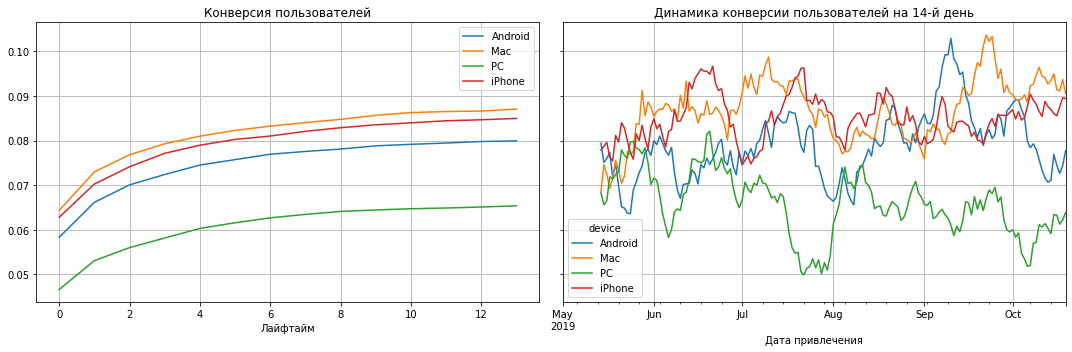

In [40]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Видмм, что пользователи Android, Mac и iPhone, несмотря на проблемы с окупаемостью, конвертируются лучше пользователей PC

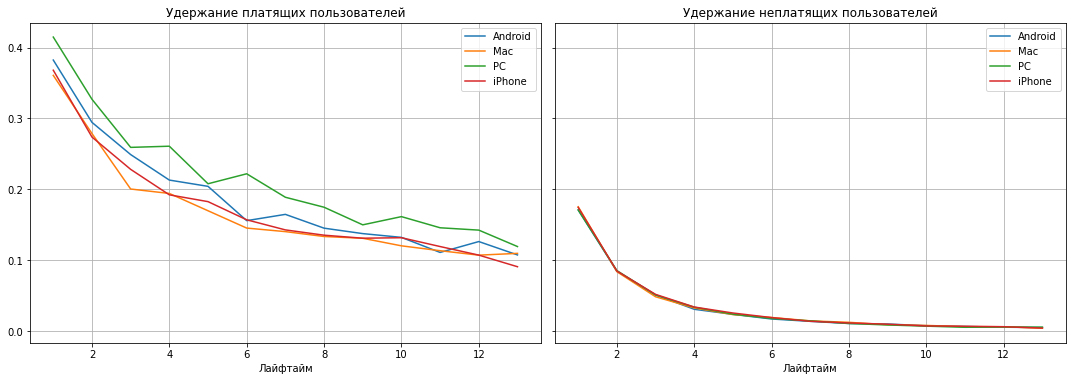

In [41]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits.query('channel != "organic"'), observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=20) 

С точки зрения retention, ситуация несколько отличается: пользователи Android, iPhone и Mac удерживаются хуже других

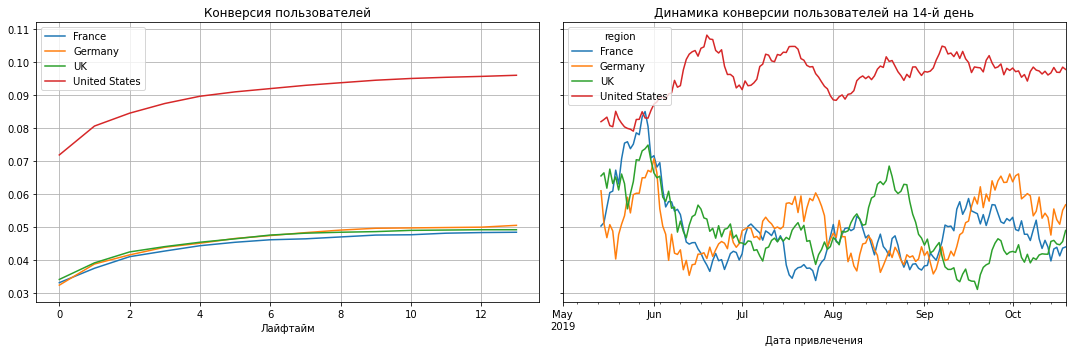

In [42]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

Видим, что пользователи из США отлично конвертируются, конверсия в покупку в 2 раза выше чем у пользователей из других стран.

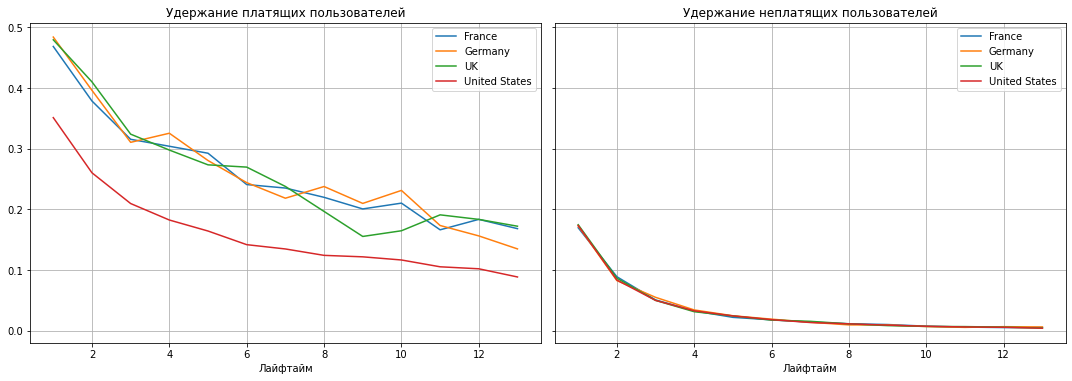

In [43]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits.query('channel != "organic"'), observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=20) 

Судя по графикам retention, проблема окупаемости пользователей из США скорее всего связана именно с их низким удержанием.

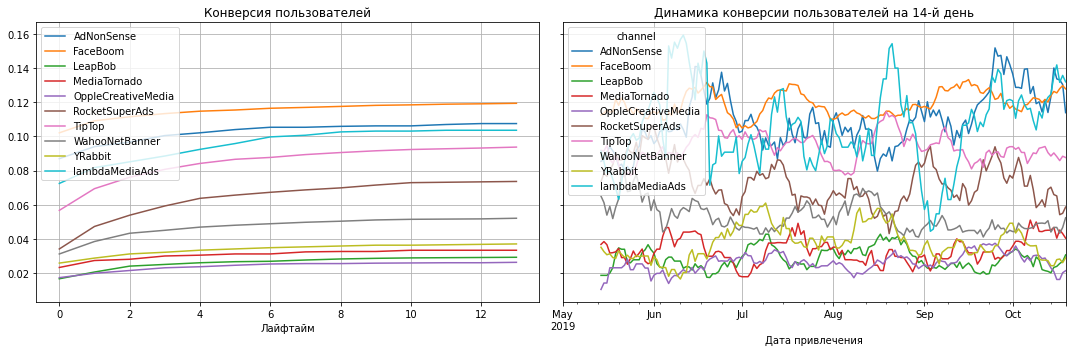

In [44]:
# смотрим конверсию с разбивкой по каналу привлечения
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel != "organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days, window=14) 

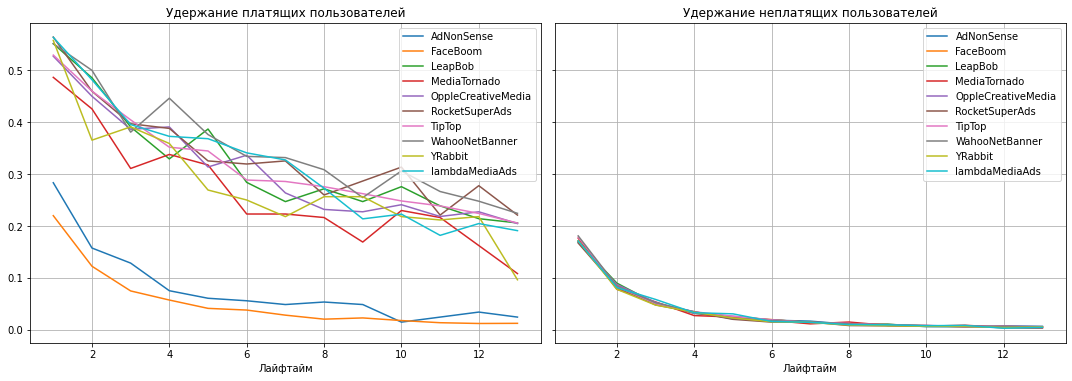

In [45]:
# смотрим удержание с разбивкой по каналу привлечения

retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel != "organic"'), visits.query('channel != "organic"'), observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days,window=14) 

При разбивке по каналу привлечения для проблемных пользователей каналов FaceBoom и AdNonSense при достаточно высокой конверсии наблюдается крайне низкий уровень удержания: на 50-60% ниже чем у других каналов

Как было показано, если рассматривать проект целиком, инвестиции в маркетинг не окупаются. 

Окупаемость рекламы могут снижать:
- Пользователи из США
- Пользователи Android, iPhone и Mac
- Пользователи, привлекаемые по каналам FaceBoom, TipTop и AdNonSense.

Проведенный retention-анализ показывает, что проблемы окупаемости вероятно связаны с низким уровнем удержания пользователей указанных групп.

# Шаг 6. Выводы

Основные причины неэффективного маркетинга связаны с низким уровнем удержания, который демонстрируют пользователи из США, пользователи Android, iPhone и Mac, а также пользователи, привлекаемые по каналам FaceBoom и AdNonSense

Таким образом, основная делятельность по повышению эффективности маркетинговой кампании должна быть нацелена на повышение удержания пользователей. В идеальном случае необходимо добиться того, чтобы у пользователей появилась привычка использовать приложение. Основные рекомендации:
- Отправлять новым пользователям push-уведомления или email-рассылку с напоминаниями о себе 
- Изменить(упростить) дизайн/оформление приложения для новичков из указанных проблемных групп. Через неделю посмотреть, в какую сторону изменился показатель. Если после очередного обновления Retention резко пошел вверх, то это повод задуматься.
- Ввести промокоды и подарки, поддерживающие интерес к продукту для новых пользователей